핸즈온 7장 앙상블 학습과 랜덤 포레스트 p.245-257(7.1 ~ 7.4)

### **[개념 정리+코드 필사]📝**


# **Chapter7. 앙상블 학습과 랜덤 포레스트**

### **7.1 투표 기반 분류기**

- 직접 투표 분류기: 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측(앙상블의 예측). 즉 다수결 투표로 정하는 분류기
  - 개별 분류기보다 성능이 더 높은 경향
  - 각 분류기가 약한 학습기여도 충분히 많고 다양하면 강한 학습기가 될 수 있음
  - **큰 수의 법칙**: 불균형한 동전을 가정했을 때 던지는 횟수가 많을수록 앞면이 나올 확률이 증가하는 법칙. 가장 많은 클래스로 예측한다면 더 높은 정확도를 기대할 수 있음
    - 모든 분류기가 독립적이고 오차에 상관관계가 없어야 가정이 가능함. (같은 데이터로 훈련X)
  - 사이킷런의 투표 기반 분류기: 📃 VotingClassifier(estimators=[], #voting='hard')

- 간접투표 분류기: 모든 개별 분류기의 예측을 평균내어 확률이 가장 높은 클래스를 예측함
  - predict_proba()로 개별 클래스의 확률을 예측
  - 확률 기반 비중을 두기 때문에 직접 투표보다 성능이 좋음
  - 사이킷런의 간접투표 분류기: 📃 VotingClassifier(estimators=[], #voting='soft')
  - SVC 분류기에서는 probabilty=True로 해야 predict_proba()사용 가능함

  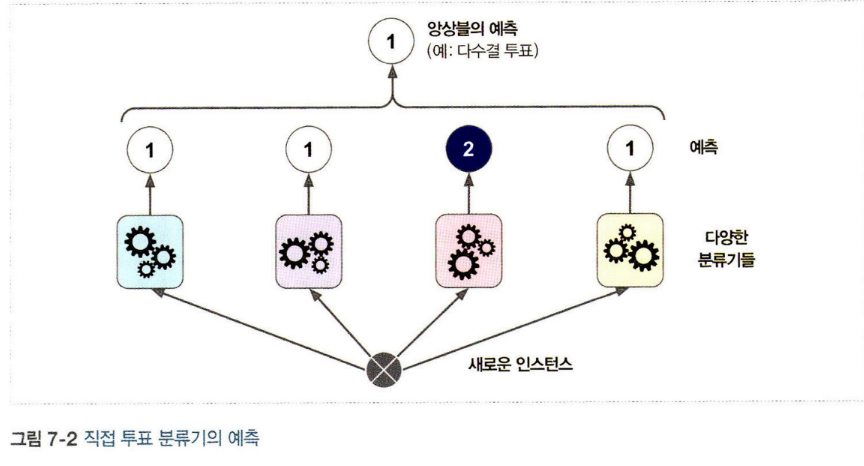





In [ ]:
import warnings
warnings.filterwarnings('ignore')
# import package
import numpy as np
import os
#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc',svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [ ]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8
RandomForestClassifier 0.95
SVC 0.95
VotingClassifier 0.95



### **7.2 배깅과 페이스팅**

- (앞에선 다양한 훈련 알고리즘을 사용)같은 알고리즘을 사용, 훈련 세트의 서브셋을 무작위 구성해 분류기를 다르게 학습시키는 것
  - 훈련세트 중복 허용 샘플링: ✅ 배깅 -> 한 예측기에 한 훈련샘플을 여러번 샘플링 가능하다는 뜻
  - 중복 허용하지 않고 샘플링: ✅ 페이스팅 -> 한 샘플을 여러 예측기엔 사용가능
  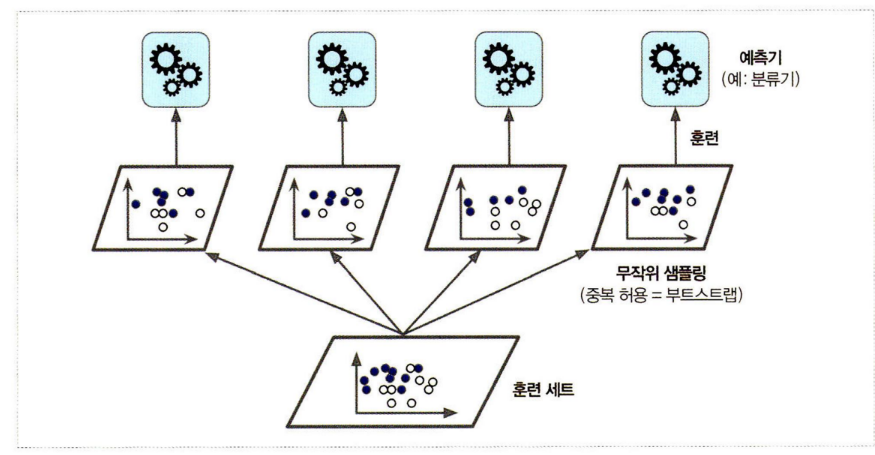

- 모든 예측기의 예측을 모아 새로운 샘플의 예측을 함. 분류 시 통계적 최빈값 / 회귀 시 평균으로 계산.
  - 개별 예측기는 수집 함수를 통과하면 편향,분산 감소 -> 결과적으로 앙상블은 하나의 예측기 사용보다 편향은 비슷하지만 분산이 줄어듦
- 예측기들을 동시에 병렬로 학습 및 예측 수행 -> 확장성


#### 📘 7.2.1 사이킷런의 배깅과 페이스팅

- 배깅: 📃 BaggingClassifier() / BaggingRegressor()
- 페이스팅: 📃 BaggingClassifier(bootstrap=False)
 - 기반 분류기가 확률 추정 가능한 분류기면 자동으로 간접 투표 방식 수행

```
📃 BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)
```

- 앙상블은 분류기 하나보다 일반화가 잘됨. 비슷한 편향에서 더 작은 분산을 가짐
  - 배깅(부트스트래핑)은 학습 서브셋에 다양성이 있어 페이스팅보다 편향이 높고 분산이 작음. 전반적으로 배깅이 더 나은 모델을 만드는 편. 배깅과 페이스팅을 모두 평가 후 선택하는 것이 가장 좋음

  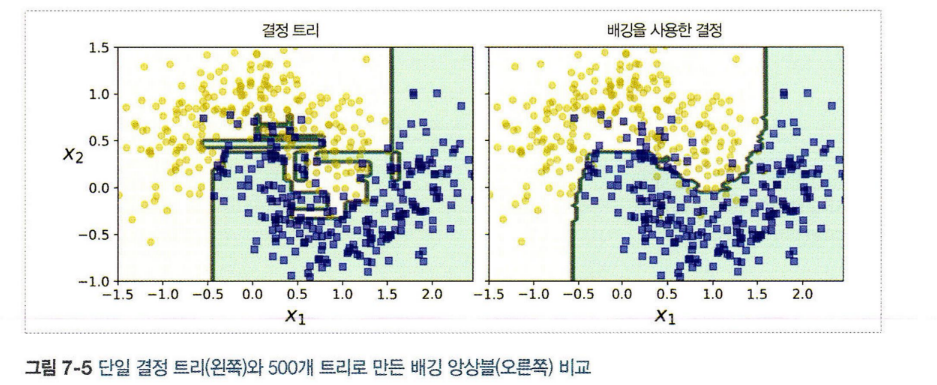




#### 📘 7.2.2 oob 평가

- 배깅은 한 예측기에 샘플을 여러 번 샘플링하기 때문에(중복허용) 선택안되는 샘플도 있음. 중복을 허용한 m개(훈련 세트의 크기)의 샘플을 선택함.
  - 훈련 샘플의 63%만 샘플링에 사용, 37%는 선택되지 않은 **oob 샘플**
- oob 평가: 예측기 훈련에는 oob 샘플 사용하지 않으므로 별도의 검증 세트 없이 평가에 사용함. 각 예측기의 oob 평가를 평균하여 앙상블 평가.
  - ✅ oob_score=True: 훈련 후 자동으로 평가수행. 결과는 oob_score_에 저장됨
    - accuracy_score과 비슷한 결과
    - oob_decision_function_: oob 샘플에 대한 결정함수 값 저장(예를 들어 predict_proba()일땐 각 클래스 확률 반환)

In [ ]:
# 7.2.1
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
y_pred

array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1])

In [ ]:
# 7.2.2
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap = True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.925

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

In [ ]:
bag_clf.oob_decision_function_

array([[0.86746988, 0.13253012],
       [1.        , 0.        ],
       [0.00574713, 0.99425287],
       [0.79207921, 0.20792079],
       [0.03468208, 0.96531792],
       [0.00584795, 0.99415205],
       [0.14516129, 0.85483871],
       [0.        , 1.        ],
       [0.98809524, 0.01190476],
       [0.06043956, 0.93956044],
       [0.        , 1.        ],
       [0.8988764 , 0.1011236 ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.12359551, 0.87640449],
       [1.        , 0.        ],
       [0.02209945, 0.97790055],
       [1.        , 0.        ],
       [0.9112426 , 0.0887574 ],
       [0.38497653, 0.61502347],
       [0.82142857, 0.17857143],
       [0.82777778, 0.17222222],
       [0.96551724, 0.03448276],
       [1.        , 0.        ],
       [0.02777778, 0.97222222],
       [0.1863354 , 0.8136646 ],
       [1.        , 0.        ],
       [0.09      , 0.91      ],
       [1.        , 0.        ],
       [0.95321637, 0.04678363],
       [0.

### **7.3 랜덤 패치와 랜덤 서브스페이스**

- BaggingClassifier의 특성 샘플링 지원
  - 특성 생플링으로 더 다양한 예측기 생성-> 편향 증가, 분산 감소
  - max_features, bootstrap_features 변수로 조절
  - 각 예측기는 무작위 입력 특성의 일부분으로 훈련됨
  - 랜덤 패치 방식: 훈련 특성+샘플 모두 샘플링
    - 📃 bootstrap_features=False, max_features=1.0
  - 랜덤 서브스페이스 방식: 훈련 샘플은 모두 사용 / 특성만 샘플링
    - 📃 bootstrap_features=True, max_features=0.8(<1.0)

### **7.4 랜덤 포레스트**

- 배깅을 적용한 결정트리의 앙상블
- max_samples: 훈련 샘플 크기로 지정
- 📃 RandomForestClassifier() == BaggingClassifier(DecisionTreeClassifier()~)
  - DecisionTreeClassifier(트리 성장 조절)+ BaggingClassifier(앙상블 제어)의 매개변수를 모두 가짐
  - 트리 노드 분할 시 무작위 특성 후보 중 회적의 특성을 찾는 식으로 무작위성 더 주입함 -> 편향 증가 대신 분산 감소로 더 훌륭한 모델이 됨
  
  ```
  - 📃 RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
  - 📃 BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators = 500, max_samples=1.0, bootstrap=True, n_jobs=-1)
  ```

#### 📘 7.4.1 엑스트라 트리

- 익스트림 랜덤 트리(엑스트라 트리): 트리 분할 시 각 노드는 무작위로 특성 서브셋을 만들어 분할에 사용. 여기에 더해 후보 특성으로 무작위 분할 후 최상의 분할 선택 --> 극단적으로 무작위한 트리의 랜덤포레스트
  - 편향 증가, 분산 감소
  - 일반 랜덤포레스트(노드에서 특성마다 최적의 임곗값 찾음)보다 훨씬 빠름
  - 📃 ExtraTreeClassifier(): RandomForestClassifier()와 사용법 같음

- 랜덤포레스트와 둘 다 시도 후 교차검증으로 비교 필요


#### 📘 7.4.2 특성 중요도

- 랜덤포레스트의 장점: 특성의 상대적 중요도 측정 쉬움.
- 사이킷런의 특성 중요도 측정: 어떤 특성을 사용한 노드가 불순도를 평균적으로 많이 감소시키는지 파악하는 방식. 즉, 각 노드의 가중치 평균.
- 📃 feature_importance_: 훈련 후 자동으로 특성마다 계산 후 결괏값을 정규화해 저장. 각 특성의 중요도 출력가능함

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.95

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators = 500, max_samples=1.0, bootstrap=True, n_jobs=-1)

In [ ]:
# max_features = 'auto' 오류로 1.0으로 변경해 추가적으로 작성함
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features=1.0, max_leaf_nodes=16),
    n_estimators = 500, max_samples=1.0, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred_bag)

0.9

In [ ]:
# 7.4.2
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.10884465144163215
sepal width (cm) 0.02724171972217494
petal length (cm) 0.43291716102111116
petal width (cm) 0.43099646781508166
